In [1]:
import sys
import seaborn as sns

sys.path.insert(1, '../../Databank/Scripts/BuildDatabank/')
from databankLibrary import download_link, lipids_dict, databank

path = '../Data/MD-PERMEATION/'
db_data = databank(path)
systems = db_data.get_systems()

/home/osollila/.conda/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")


In [367]:
import matplotlib.pyplot as plt
import json
import numpy as np
import pandas as pd
import seaborn as sn
import os
import scipy.stats
from scipy import stats
import scipy.optimize
import math

def CalcAreaPerMolecule(system):
    path = system['path']
    APLpath = path.replace('../Data/MD-PERMEATION/', '../../Databank/Data/Simulations/')
    APLpath = APLpath + 'apl.json'
    #try:
    f = open(APLpath)
    APLdata = json.load(f)
    sumAPL = 0
    sumIND = 0
    for i,j in APLdata.items():
        sumAPL += j
        sumIND += 1
    APL = sumAPL/sumIND
    return(APL)
    #except:
    #    print('apl.json not found from' + APLpath)
        
def calcArea(system):
    APL = CalcAreaPerMolecule(system)
    Nlipid = 0
    for molecule in system['COMPOSITION']:
        if molecule in lipids_dict:
            Nlipid += np.sum(system['COMPOSITION'][molecule]['COUNT'])
    return Nlipid*APL/2

def GetThickness(system):
    path = system['path']
    ThicknessPath = path.replace('../Data/MD-PERMEATION/', '../../Databank/Data/Simulations/')
    ThicknessPath = ThicknessPath + 'thickness.json'
    #try:
    f = open(ThicknessPath)
    thickness = json.load(f)
    return(thickness)
    #except:
    #    pass
    #    print('thickness.json not found from' + system['path'])
    

def calcLipidFraction(system, lipid):
    NlipidTOT = 0
    for molecule in system['COMPOSITION']:
        if molecule in lipids_dict:
            NlipidTOT += np.sum(system['COMPOSITION'][molecule]['COUNT'])
    
    Nlipid = 0
    for molecule in system['COMPOSITION']:
        if lipid in molecule:
            Nlipid += np.sum(system['COMPOSITION'][molecule]['COUNT'])
            
    return Nlipid/NlipidTOT

def chargedFraction(system):
    Nlipid = 0
    for molecule in system['COMPOSITION']:
        if molecule in lipids_dict:
            Nlipid += np.sum(system['COMPOSITION'][molecule]['COUNT'])
    
    Ncharged = 0
    chargedlipids = ['POPG', 'POPS', 'DPPG', 'DOPS', 'POPI', 'SAPI', 'SLPI', 'DHMDMAB']
    for molecule in system['COMPOSITION']:
        if molecule in chargedlipids:
            Ncharged += np.sum(system['COMPOSITION'][molecule]['COUNT'])
            
    return Ncharged/Nlipid


def getHydrationLevel(system):
    Nlipid = 0
    for molecule in system['COMPOSITION']:
        if molecule in lipids_dict:
            Nlipid += np.sum(system['COMPOSITION'][molecule]['COUNT'])
    Nwater = system['COMPOSITION']['SOL']['COUNT']
    return Nwater/Nlipid


def getWaterPermeationRate(system):
    path = system['path']
    with open(path + 'Counting_events.txt', 'r') as f:
        last_line = f.readlines()[-1]
    last_line = last_line.split()
    time = float(last_line[0])
    count = float(last_line[1])
    area = calcArea(system)
    #rate = count / (time * area)  #1/(ns*Å^2)
    rate = count / (time)  #1/ns
    thickness = GetThickness(system)*10
    Nwater = system['COMPOSITION']['SOL']['COUNT']
    P = 0.5*rate*10**9/(area*10**-20 * 33.3679*10**27)
    return P*10**6  # micrometer per second

def getWaterLateralDiffusion(system):
    path = system['path']
    waterDIFFUSIONpath = path.replace('../Data/MD-PERMEATION/', '../Data/WATERdiffusion/')
    waterDIFFUSIONpath = waterDIFFUSIONpath + 'WATERlateralMSD.xvg'
    D = float(os.popen('grep D ' + waterDIFFUSIONpath + " | grep = | awk '{print $5}'").read())
    return D
    
def plotCorrelation(xProperty,yProperty,permeationResults):
    xPropertyData = []
    yPropertyData = []
    for ID in permeationResults:
        xPropertyData.append(permeationResults[ID][xProperty])
        yPropertyData.append(permeationResults[ID][yProperty])
    plt.plot(xPropertyData,yPropertyData,'.')
    
def plotXaveragedData(xProperty,yProperty,permeationResults,rounddec):
    avetemp = {}
    for ID in permeationResults:
        #print(permeationVStemperature[ID])
        temperature = round(permeationVStemperature[ID][xProperty], rounddec)
        if temperature not in avetemp.keys():
            avetemp[temperature] = {}
            avetemp[temperature]['values'] = []
            avetemp[temperature]['weigths'] = []
        avetemp[temperature]['values'].append(permeationVStemperature[ID][yProperty])
        avetemp[temperature]['weigths'].append(permeationVStemperature[ID]['SimLenght']) 
        #print(permeationVStemperature[ID]['permeation'], permeationVStemperature[ID]['temperature'])
    
    xPropertyData = []
    yPropertyData = []
    yPropertyDataError = []
    for temp in avetemp:
        #if len(avetemp[temp]['values']) < 3:
        #    continue
        if np.sum(avetemp[temp]['weigths']) < 1000000:
            continue
        average = np.average(avetemp[temp]['values'], weights = avetemp[temp]['weigths'])
        variance = np.average((avetemp[temp]['values']-average)**2, weights = avetemp[temp]['weigths'])
        xPropertyData.append(temp)
        yPropertyData.append(average)
        yPropertyDataError.append(math.sqrt(variance)/math.sqrt(len(avetemp[temp]['values'])))
        #yPropertyDataError.append(math.sqrt(variance))
    #print(yPropertyDataError)
    plt.errorbar(xPropertyData,yPropertyData, yerr=yPropertyDataError, marker = ".", linestyle='')
    #plt.errorbar(result[0],result[1], yerr=result[2], marker = ".", linestyle='')
    return xPropertyData,yPropertyData,yPropertyDataError     
    
def averageOrderParameters(system):
    
    #DataBankPath = '../../Databank/Data/'
    #path = DataBankPath + system['path']
    
    pathTMP = system['path']
    path = pathTMP.replace('../Data/MD-PERMEATION/', '../../Databank/Data/Simulations/')
    
    sn1sum = 0
    sn1count = 0
    sn2sum = 0
    sn2count = 0
    
    for lipid in system['COMPOSITION']:
        if lipid in lipids_dict and not 'CHOL' in lipid:
            OPpathSIM = path + lipid + 'OrderParameters.json'
            with open(OPpathSIM) as json_file:
                OPsim = json.load(json_file)
    
            for key in OPsim:
                if 'M_G1C' in key:
                    sn1sum += float(OPsim[key][0][0])
                    sn1count += 1
                elif 'M_G2C' in key:
                    sn2sum += float(OPsim[key][0][0])
                    sn2count += 1
                    
    return sn1sum/sn1count, sn2sum/sn2count



In [276]:
permeationVStemperature = {}
ID = 0
for system in systems:
    path = system['path']
    
    try:
        rate = getWaterPermeationRate(system)
    except:
        print('Water permeation failed, setting rate to 0: ' + path)
        rate = 0
        #continue
    
    if rate == 0:
        continue
    
    WaterLateralDiffusion = getWaterLateralDiffusion(system)
    
    if WaterLateralDiffusion > 15:
        continue
    
    #if rate > 0:
    PermeationDiffusionRatio = rate/WaterLateralDiffusion
    #else:
    #    PermeationDiffusionRatio = 'nan'
    
    APL = CalcAreaPerMolecule(system)
    
    try:
        thickness = GetThickness(system)
    except:
        thickness = 0 #float('nan')

    #if thickness < 3:
    #    continue
        
    area = calcArea(system)   
    
    tailOPavg = np.average(averageOrderParameters(system))
    #print(tailOPavg)
    if str(tailOPavg) == 'nan':
        print(system)
    
    sn1OPavg = averageOrderParameters(system)[0]
    sn2OPavg = averageOrderParameters(system)[1]
    
    hydration = getHydrationLevel(system)
    
    CholFraction = calcLipidFraction(system, 'CHOL')
    
    POPGFraction = calcLipidFraction(system, 'POPG')
    
    POPSFraction = calcLipidFraction(system, 'POPS')
    
    POPEFraction = calcLipidFraction(system, 'POPE')
    
    ChargedFraction = chargedFraction(system)
    
    temperature = system['TEMPERATURE']
    
    #if temperature > 315 or temperature < 300:
    #    continue
    
    SimLength = system['TRJLENGTH'] - system['PREEQTIME']
    
    try:
        ForceField = system['FF']
    except:
        ForceField = 'Unknown'
    
    if thickness == 0:
        continue
    
    ID += 1
    permeationVStemperature[ID] = {
        'path': path, 
        'permeation': rate, 
        'WaterLateralDiffusion' : WaterLateralDiffusion,
        'APL': APL, 
        'volume': APL*thickness,
        'thickness': thickness,
        'TailOrder' : tailOPavg,
        #'sn1Order' : sn1OPavg,
        #'sn2Order' : sn2OPavg,
        'hydration': hydration,
        'temperature': temperature ,
        'ChargedFraction': ChargedFraction,
        'CholFraction': CholFraction,
        'POPGFraction': POPGFraction,
        'POPSFraction': POPSFraction,
        'POPEFraction': POPEFraction,
        'ForceField': ForceField,
        'SimLenght': SimLength,
        #'PermeationDiffusionRatio' : PermeationDiffusionRatio,
        'area' : area,
    }
        
        
    #!ls {path}
    #for key in system:
    #    print(key, ':',system[key])
    #print('')

Water permeation failed, setting rate to 0: ../Data/MD-PERMEATION/019/eb8/019eb8d7691998587faa1e618272a564ff9e697e/577a6cc9d00effd20baf941d520a23d91701352d/
Water permeation failed, setting rate to 0: ../Data/MD-PERMEATION/02b/984/02b98418d9965749ac943ecae9627cfdd1dfbdcd/7339faa76da6c93cfee03e59f399e2eed1628b53/
Water permeation failed, setting rate to 0: ../Data/MD-PERMEATION/0a2/272/0a22727a0659852772b4a1193ced99c5981fb739/973cf49703e3217f44b5c18759fd8926e8f5d1f1/
Water permeation failed, setting rate to 0: ../Data/MD-PERMEATION/0a4/101/0a41017641414540973e921ed22528d1f3dc414b/3c0936e61fa40cce74fd1828a2697742709e91fb/
Water permeation failed, setting rate to 0: ../Data/MD-PERMEATION/0b0/917/0b0917aff71a271c294c0a5aa50dc1232b2f7b19/82ff8d2baa8e6e66a638d92308cc33430a39fabb/
Water permeation failed, setting rate to 0: ../Data/MD-PERMEATION/0bc/296/0bc296850dd41d32a6e9aa4ac2b5dd4e84a6605f/e64b1a6ceccc9a361529be902c17c2b4b0394484/
Water permeation failed, setting rate to 0: ../Data/MD-PER

Water permeation failed, setting rate to 0: ../Data/MD-PERMEATION/e95/22c/e9522c15b02896745581a44703fd2211e0680422/acee48b47743b28e0dfd31437aca72f364c2edd7/
Water permeation failed, setting rate to 0: ../Data/MD-PERMEATION/e98/55c/e9855c9d36a1dabc244570c99332c1df87333dbe/09332e7c0462dcb58a2d717fd760057c08726706/
Water permeation failed, setting rate to 0: ../Data/MD-PERMEATION/ea0/d5a/ea0d5a1550d15ecabd0ffc0a27f59a7c01f61b83/570401bcf40f667dc9b035d8d5519aeb4a3fa072/
Water permeation failed, setting rate to 0: ../Data/MD-PERMEATION/ce5/80e/ce580ea7b4e991122666ed4fc3c779e3783cbc95/e2c64d1a46b3571951cce2c90ab7302a8f300a9b/
Water permeation failed, setting rate to 0: ../Data/MD-PERMEATION/d0c/cca/d0cccab96a52325d65e1be3e59706c5215911089/5dd86a4c1e65de95673d1f5ebdc685d6eb1fc155/
Water permeation failed, setting rate to 0: ../Data/MD-PERMEATION/d1b/fe4/d1bfe472aaefaa4991e8b6ddb3a888cdeeb6a7ad/870f1ea073265c465676161147d9037a9a2253e3/
Water permeation failed, setting rate to 0: ../Data/MD-PER

Water permeation failed, setting rate to 0: ../Data/MD-PERMEATION/351/942/3519421ff6c7df40e1da7ac6b6e9ea4d06c911ca/1419f364222a22aadc90d4ec0963e18173e1df2a/
Water permeation failed, setting rate to 0: ../Data/MD-PERMEATION/354/c96/354c960d52ae3ede20ac62f39f791a4ba9892659/b73fc91c765a75d02c0c9fbc87e400dc79221c44/
Water permeation failed, setting rate to 0: ../Data/MD-PERMEATION/370/8fe/3708fe5639902a0ec0b60ba2c4fdb7711184c6bb/a15498a0795561646a76b01370ec8fd493593df4/
Water permeation failed, setting rate to 0: ../Data/MD-PERMEATION/371/d53/371d534a1bb41fd81e137717e473e6916c9bbf70/7c24007a3d9cbe605a31999850e929ebfaf530f7/
Water permeation failed, setting rate to 0: ../Data/MD-PERMEATION/372/a91/372a917a2f528473eef642569a4c4f5f7472d473/e23ae04f10840187c2cf50c92451226d6bbadf63/


13.799872578256142


/home/osollila/.conda/envs/py39/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

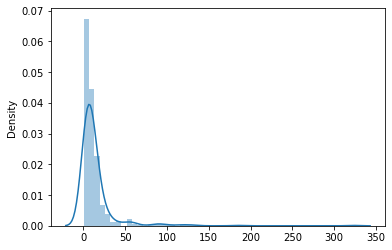

In [281]:
#print(system)
perm = []
sumIND = 0
sumPERM = 0
for i in permeationVStemperature:
    permeation = permeationVStemperature[i]['permeation']
    #if permeation*10**-6 > 0.5*10**-4:
    #    print(permeation, permeationVStemperature[i])
    #    continue
    perm.append(permeation)
    sumPERM += permeationVStemperature[i]['permeation']
    sumIND += 1
    #sumPERM += permeationVStemperature[i]['SimLenght'] * permeationVStemperature[i]['permeation']
    #sumIND += permeationVStemperature[i]['SimLenght']
print(sumPERM/sumIND)

sns.distplot(perm)

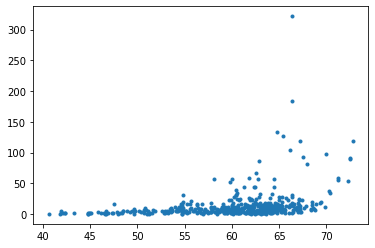

In [330]:
plotCorrelation('APL','permeation',permeationVStemperature)
#plt.ylim([0,100])

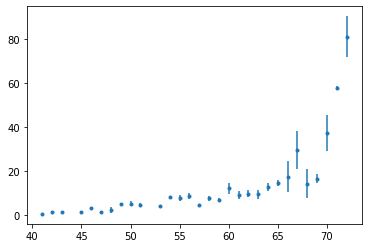

In [390]:
result = plotXaveragedData('APL','permeation',permeationVStemperature,0)
#plt.errorbar(result[0],result[1], yerr=result[2], marker = ".", linestyle='')
#plt.ylim([0,20])

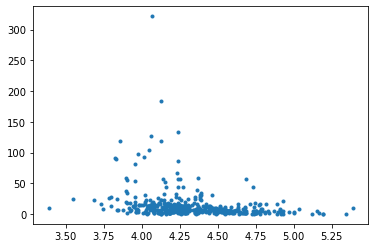

In [331]:
plotCorrelation('thickness','permeation',permeationVStemperature)
#plt.ylim([0,0.2])
#plt.xlim([3,6])

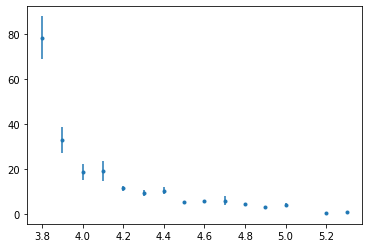

In [388]:
result = plotXaveragedData('thickness','permeation',permeationVStemperature,1)
#plt.ylim([0,20])

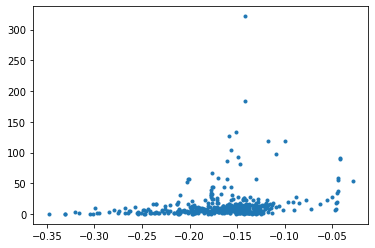

In [262]:
plotCorrelation('TailOrder','permeation',permeationVStemperature)
#plt.ylim([0,0.2])

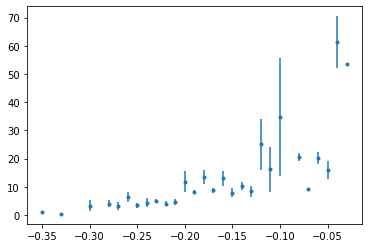

In [370]:
result = plotXaveragedData('TailOrder','permeation',permeationVStemperature,2)

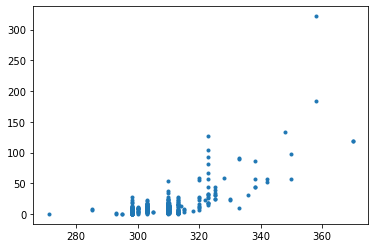

In [264]:
plotCorrelation('temperature','permeation',permeationVStemperature)
#plt.ylim([0,0.2])

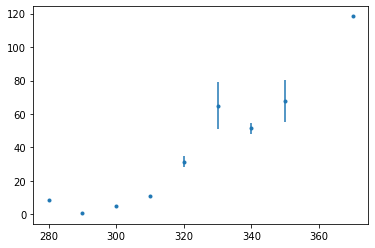

-0.016582379819356455 0.003926012415433712
LinregressResult(slope=-4.941549186168224, intercept=18.418487383287893, rvalue=-0.8474634941892887, pvalue=0.003918491927388986, stderr=1.1699516997992463, intercept_stderr=3.683839082187409)


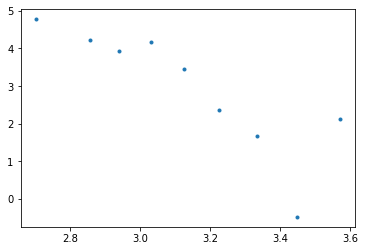

In [386]:
results = plotXaveragedData('temperature','permeation',permeationVStemperature,-1)
#plt.ylim([-10,10])
plt.show()

itemp = []
logP = []
for i in range(len(results[0])):
    itemp.append(1000*1/results[0][i])
    logP.append(np.log(results[1][i]))
    #plt.plot(1/results[0][i],np.log(results[1][i]),".")

plt.plot(itemp,logP,".")
fitResult = scipy.stats.linregress(itemp, logP)
print(fitResult[0] / 298, fitResult[4] / 298)
print(fitResult)


In [372]:
results

([300.0, 310.0, 320.0, 340.0, 370.0, 350.0, 330.0, 280.0, 290.0],
 [5.264470708822079,
  10.718872681436624,
  31.54350275880478,
  51.41322063227283,
  118.41327464238691,
  67.8308537275954,
  65.07817893626986,
  8.369919443795473,
  0.6220265756950653],
 [0.37460818710785637,
  0.5888066172285471,
  3.5055509491641526,
  3.1489669043739132,
  0.005297411530693096,
  12.537482553048543,
  13.951324665484838,
  0.4567854490990298,
  0.32788379484812796])

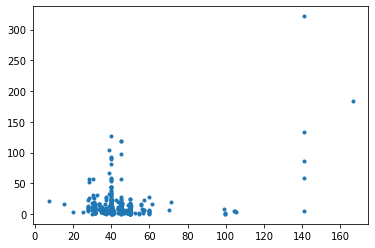

In [267]:
plotCorrelation('hydration','permeation',permeationVStemperature)
#plt.ylim([0,0.2])

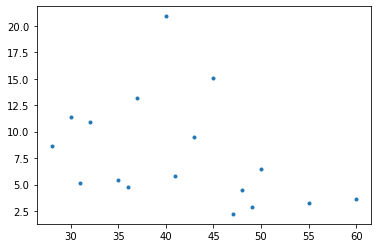

In [268]:
plotXaveragedData('hydration','permeation',permeationVStemperature,0)

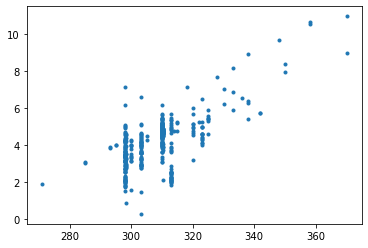

In [269]:
plotCorrelation('temperature','WaterLateralDiffusion',permeationVStemperature)

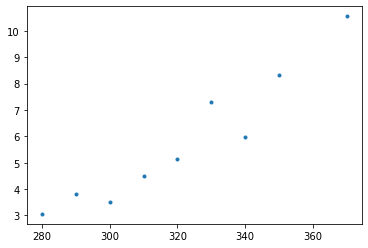

In [270]:
plotXaveragedData('temperature','WaterLateralDiffusion',permeationVStemperature,-1)

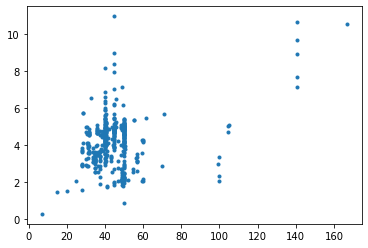

In [245]:
plotCorrelation('hydration','WaterLateralDiffusion',permeationVStemperature)
#plt.ylim([0,11])

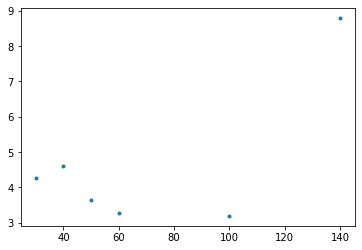

In [246]:
plotXaveragedData('hydration','WaterLateralDiffusion',permeationVStemperature,-1)

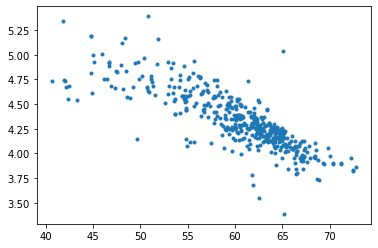

In [294]:
plotCorrelation('APL','thickness',permeationVStemperature)

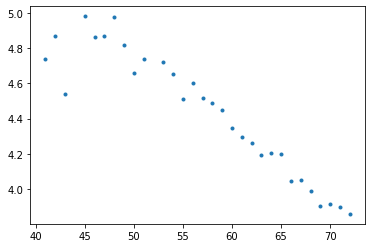

In [295]:
plotXaveragedData('APL','thickness',permeationVStemperature,0)

In [174]:
plotCorrelation('hydration','PermeationDiffusionRatio',permeationVStemperature)
#plt.ylim([0,0.05])

KeyError: 'PermeationDiffusionRatio'

In [ ]:
plotCorrelation('ChargedFraction','permeation',permeationVStemperature)
plt.ylim([0,50])

In [ ]:
plotCorrelation('CholFraction','permeation',permeationVStemperature)
plt.ylim([0,50])

In [ ]:
plotCorrelation('POPSFraction','APL',permeationVStemperature)

In [ ]:
data = {}
for prop in permeationVStemperature[1]:
    if prop == 'path':
        continue
    data[prop] = []

for ID in permeationVStemperature:
    for prop in permeationVStemperature[ID]:
        if prop == 'path':
            continue
        data[prop].append(permeationVStemperature[ID][prop])
        #print(ID,prop)

columns = []
for i in data:
    columns.append(i)

df = pd.DataFrame(data,columns=columns)
#print (df)

In [ ]:
corrMatrix = df.corr()
#print (corrMatrix)
plt.figure(figsize = (20,10))
sn.heatmap(corrMatrix, annot=True)

plt.show()


In [ ]:
scipy.stats.pearsonr(data['ChargedFraction'],data['APL'])

In [ ]:
scipy.stats.spearmanr(data['ChargedFraction'],data['APL'])

In [ ]:
df

In [ ]:
from scipy import stats

def corrfunc(x, y, **kws):
  r, p = stats.pearsonr(x, y)
  p_stars = ''
  if p <= 0.05:
    p_stars = '*'
  if p <= 0.01:
    p_stars = '**'
  if p <= 0.001:
    p_stars = '***'
  ax = plt.gca()
  ax.annotate('r = {:.2f} '.format(r) + p_stars,
              xy=(0.05, 0.9), xycoords=ax.transAxes)


def annotate_colname(x, **kws):
  ax = plt.gca()
  ax.annotate(x.name, xy=(0.05, 0.9), xycoords=ax.transAxes,
              fontweight='bold')

g = sn.PairGrid(df, palette=['red'])
  # Use normal regplot as `lowess=True` doesn't provide CIs.
g.map_upper(sn.regplot, scatter_kws={'s':10})#, lowess = True)
g.map_diag(sn.histplot, kde= True)
g.map_diag(annotate_colname)
g.map_lower(sn.kdeplot, cmap='Blues_d')
g.map_lower(corrfunc)
# Remove axis labels, as they're in the diagonals.
for ax in g.axes.flatten():
    ax.set_ylabel('')
    ax.set_xlabel('')
g
g.figure.savefig("correlations.pdf")

In [ ]:
from scipy import stats

def corrfunc(x, y, **kws):
  #r, p = stats.pearsonr(x, y)
  r, p = stats.spearmanr(x, y)
  p_stars = ''
  if p <= 0.05:
    p_stars = '*'
  if p <= 0.01:
    p_stars = '**'
  if p <= 0.001:
    p_stars = '***'
  ax = plt.gca()
  ax.annotate('r = {:.2f} '.format(r) + p_stars,
              xy=(0.05, 0.9), xycoords=ax.transAxes)


def annotate_colname(x, **kws):
  ax = plt.gca()
  ax.annotate(x.name, xy=(0.05, 0.9), xycoords=ax.transAxes,
              fontweight='bold')

g = sn.PairGrid(df, palette=['red'])
  # Use normal regplot as `lowess=True` doesn't provide CIs.
g.map_upper(sn.regplot, scatter_kws={'s':10}, order = 1, robust = True ) #lowess = True)
g.map_diag(sn.histplot, kde= True)
g.map_diag(annotate_colname)
g.map_lower(sn.kdeplot, cmap='Blues_d')
g.map_lower(corrfunc)
# Remove axis labels, as they're in the diagonals.
for ax in g.axes.flatten():
    ax.set_ylabel('')
    ax.set_xlabel('')
g
g.figure.savefig("correlations.pdf")

In [ ]:
def CalcCorrCoeff(prop1,prop2):
    #prop1 = 'hydration'
    #prop2 = 'WaterLateralDiffusion'

    list1 = []
    list2 = []
    for ID in permeationVStemperature:
        #print(permeationVStemperature[ID])
        value1 = permeationVStemperature[ID][prop1]
        value2 = permeationVStemperature[ID][prop2]
        #if permeationVStemperature[ID][prop1] < 30:
        list1.append(value1)
        list2.append(value2)

    #print(stats.spearmanr(list1, list2))
    r, p = stats.pearsonr(list1, list2)

    p_stars = ''
    if p <= 0.05:
        p_stars = '*'
    if p <= 0.01:
        p_stars = '**'
    if p <= 0.001:
        p_stars = '***'
    
    ax = plt.gca()
    ax.annotate('r = {:.2f} '.format(r) + p_stars,
              xy=(0.05, 0.9), xycoords=ax.transAxes)

    sn.regplot(x=list1,y=list2, scatter_kws={'s':10})
    #return r, p_stars

plt.figure(figsize=(20,5))

properties = ['APL', 
             'thickness',
             # 'volume',
             'TailOrder',
             #'sn1Order',
             #'sn2Order',
             'hydration',
              'temperature',
              'ChargedFraction',
              'CholFraction',
              'POPGFraction',
              'POPSFraction',
              'POPEFraction'
             ]

for i in range(1,11):
    #print(i)
    
    plt.subplot(2, 10, i)
    plt.title(properties[i-1])
    if i == 1:
        plt.ylabel('Permeation')
    else:
        plt.yticks(color = 'w')
    CalcCorrCoeff(properties[i-1],'permeation')
    
    plt.subplot(2, 10, i+10)
    if i+10 == 11:
        plt.ylabel('Water lateral diffusion')
    else:
        plt.yticks(color = 'w')
    CalcCorrCoeff(properties[i-1],'WaterLateralDiffusion')

In [ ]:
plt.figure(figsize=(20,5))

properties = ['APL', 
             'thickness',
             'TailOrder',
             #'hydration',
              'temperature',
              #'ChargedFraction',
              #'CholFraction',
              #'POPGFraction',
              #'POPSFraction',
              #'POPEFraction'
             ]

for i in range(1,5):
    #print(i)
    
    plt.subplot(2, 7, i)
    plt.title(properties[i-1])
    if i == 1:
        plt.ylabel('Permeation')
    else:
        plt.yticks(color = 'w')
    CalcCorrCoeff(properties[i-1],'permeation')
    
    plt.subplot(2, 7, i+7)
    if i+7 == 8:
        plt.ylabel('Water lateral diffusion')
    else:
        plt.yticks(color = 'w')
    CalcCorrCoeff(properties[i-1],'WaterLateralDiffusion')
    
plt.savefig('PermDiffDep.pdf')

In [ ]:
def CalcCorrCoeffFilterHYD(prop1,prop2):
    #prop1 = 'hydration'
    #prop2 = 'WaterLateralDiffusion'

    list1 = []
    list2 = []
    for ID in permeationVStemperature:
        #print(permeationVStemperature[ID])
        value1 = permeationVStemperature[ID][prop1]
        value2 = permeationVStemperature[ID][prop2]
        if permeationVStemperature[ID]['hydration'] < 30:
            list1.append(value1)
            list2.append(value2)

    #print(stats.spearmanr(list1, list2))
    r, p = stats.pearsonr(list1, list2)

    p_stars = ''
    if p <= 0.05:
        p_stars = '*'
    if p <= 0.01:
        p_stars = '**'
    if p <= 0.001:
        p_stars = '***'
    
    ax = plt.gca()
    ax.annotate('r = {:.2f} '.format(r) + p_stars,
              xy=(0.05, 0.9), xycoords=ax.transAxes)

    sn.regplot(x=list1,y=list2, scatter_kws={'s':10})
    #return r, p_stars



plt.figure(figsize=(5,30))

properties = ['APL', 
             'thickness',
             'TailOrder',
              'WaterLateralDiffusion',
              'permeation'
             #'hydration',
             # 'temperature',
              #'ChargedFraction',
              #'CholFraction',
             #'POPGFraction',
             #'POPSFraction',
             #'POPEFraction'
             ]

for i in range(1,6):
    #print(i)
    
    plt.subplot(8, 1, i)
    if i ==1:
        plt.title('hydration')
    plt.ylabel(properties[i-1])
    #else:
    #    plt.yticks(color = 'w')
    CalcCorrCoeffFilterHYD('hydration',properties[i-1])
    
    #plt.subplot(2, 7, i+7)
    #if i+7 == 8:
    #    plt.ylabel('Water lateral diffusion')
    #else:
    #    plt.yticks(color = 'w')
    #CalcCorrCoeff(properties[i-1],'WaterLateralDiffusion')

In [ ]:
prop1 = 'APL'
prop2 = 'permeation'

list1 = []
list2 = []
for ID in permeationVStemperature:
    #print(permeationVStemperature[ID])
    value1 = permeationVStemperature[ID][prop1]
    value2 = permeationVStemperature[ID][prop2]
    if permeationVStemperature[ID]['permeation'] < 0.1:
        list1.append(value1)
        list2.append(value2)

#print(stats.spearmanr(list1, list2))
r, p = stats.pearsonr(list1, list2)

p_stars = ''
if p <= 0.05:
    p_stars = '*'
if p <= 0.01:
    p_stars = '**'
if p <= 0.001:
    p_stars = '***'
    
ax = plt.gca()
ax.annotate('r = {:.2f} '.format(r) + p_stars,
              xy=(0.05, 0.9), xycoords=ax.transAxes)

sn.regplot(x=list1,y=list2, scatter_kws={'s':10})#, order = 2)

In [ ]:
prop1 = 'thickness'
prop2 = 'permeation'

list1 = []
list2 = []
for ID in permeationVStemperature:
    #print(permeationVStemperature[ID])
    value1 = permeationVStemperature[ID][prop1]
    value2 = permeationVStemperature[ID][prop2]
    if permeationVStemperature[ID]['thickness'] > 3 and permeationVStemperature[ID]['permeation'] < 0.1:
        list1.append(value1)
        list2.append(value2)

#print(stats.spearmanr(list1, list2))
r, p = stats.pearsonr(list1, list2)

p_stars = ''
if p <= 0.05:
    p_stars = '*'
if p <= 0.01:
    p_stars = '**'
if p <= 0.001:
    p_stars = '***'
    
ax = plt.gca()
ax.annotate('r = {:.2f} '.format(r) + p_stars,
              xy=(0.05, 0.9), xycoords=ax.transAxes)

sn.regplot(x=list1,y=list2, scatter_kws={'s':10})#, order = 2)

In [ ]:
for i in range(1, 7):
    plt.subplot(2, 3, i)
    plt.text(0.5, 0.5, str((2, 3, i)),
             fontsize=18, ha='center')

In [ ]:
CHARMMsum = 0
CHARMMcount = 0
OTHERsum = 0
OTHERcount = 0


for i in permeationVStemperature:
    if permeationVStemperature[i]['temperature'] > 311:
        continue
    FF = permeationVStemperature[i]['ForceField']
    permeation = permeationVStemperature[i]['permeation']
    if 'CHARMM' in FF:
        CHARMMsum += permeation
        CHARMMcount += 1
    else:
        OTHERsum += permeation
        OTHERcount += 1
        
print(CHARMMsum/CHARMMcount, OTHERsum/OTHERcount)

In [ ]:
PermSum = 0
count = 0

for system in systems:
    try:
        rate = getWaterPermeationRate(system)
    except:
        continue
    
    POPCFraction = calcLipidFraction(system, 'POPC')
    if POPCFraction !=1:
        continue
        
    try:
        print(system['FF'],rate)
    except:
        continue
    
    if 'erger' in system['FF']:
        PermSum += rate
        count += 1
    else:
        continue

print(PermSum/count)

In [ ]:
def NagleFunct(x, a, g):
    iP = a*x[0]/(x[0]-48) + g*x[1]
    return iP

APLthick = []
permeation = []
for ID in permeationVStemperature:
    permeation.append(permeationVStemperature[ID]['permeation'])
    APLthick.append([permeationVStemperature[ID]['APL'], permeationVStemperature[ID]['thickness']])
    
scipy.optimize.curve_fit(NagleFunct, APLthick, permeation)

In [ ]:
len(APLthick)

#for i in APLthick:
#    print(NagleFunct(i,1,1))

In [ ]:
import numpy as np
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a*np.sin(x[0])+b*np.cos(x[1])+c

limits = [0, 2*np.pi, 0, 2*np.pi]  # [x1_min, x1_max, x2_min, x2_max]
side_x = np.linspace(limits[0], limits[1], 100)
side_y = np.linspace(limits[2], limits[3], 100)
X1, X2 = np.meshgrid(side_x, side_y)
size = X1.shape
x1_1d = X1.reshape((1, np.prod(size)))
x2_1d = X2.reshape((1, np.prod(size)))

xdata = np.vstack((x1_1d, x2_1d))
original = (3, 1, 0.5)
z = func(xdata, *original)
Z = z.reshape(size)
z_noise = z + .2*np.random.randn(len(z))
Z_noise = z_noise.reshape(size)

ydata = z_noise
popt, pcov = curve_fit(func, xdata, ydata)
print("original: {}\nfitted: {}".format(original, popt))
z_fit = func(xdata, *popt)
Z_fit = z_fit.reshape(size)

import matplotlib.pyplot as plt
plt.subplot(1, 3, 1)
plt.title("Real Function")
plt.pcolormesh(X1, X2, Z)
plt.axis(limits)
plt.colorbar()
plt.subplot(1, 3, 2)
plt.title("Function w/ Noise")
plt.pcolormesh(X1, X2, Z_noise)
plt.axis(limits)
plt.colorbar()
plt.subplot(1, 3, 3)
plt.title("Fitted Function from Noisy One")
plt.pcolormesh(X1, X2, Z_fit)
plt.axis(limits)
plt.colorbar()

plt.show()

In [ ]:
xdata

In [ ]:
ydata

In [ ]:
tst = np.empty([0],[0])

In [ ]:
tst

In [ ]:
np.append([1],[1])

In [ ]:
def NagleFunct(x, a, g):
    #iP = a*x[0]/(x[0]-48) + g*x[1]
    #return 1/iP
    P = a*x[0] + g*x[1]
    return P
    

APL = []
thick = []
permeation = []
for ID in permeationVStemperature:
    permeation.append(permeationVStemperature[ID]['permeation'])
    APL.append(permeationVStemperature[ID]['APL'])
    thick.append(permeationVStemperature[ID]['thickness']*10)

x = np.asarray(APL)
y = np.asarray(thick)
X1, X2  = np.meshgrid(x,y)
#size = X1.shape
#x1_1d = X1.reshape((1, np.prod(size)))
#x2_1d = X2.reshape((1, np.prod(size)))
#xdata = np.vstack((X1, X2))
xdata = np.vstack((x, y))


ydata = np.asarray(permeation)
#ydata = ydata.reshape(size)

scipy.optimize.curve_fit(NagleFunct, xdata, ydata)

In [ ]:
xdata

In [ ]:
theo = []
sim = []
for i in range(len(APL)):
    theo.append(NagleFunct([APL[i],thick[i]], 0.38478557, -0.30789772))
    sim.append(permeation[i])
    #print(theo[i],sim[i])
plt.plot(theo,sim,".")
plt.ylim(0,20)
plt.xlim(0,20)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for i in range(len(APL)):
    ax.scatter(thick[i],APL[i],permeation[i])
#for angle in range(0, 360):

y = np.linspace(30, 60, 30)
x = np.linspace(50, 70, 30)

X, Y = np.meshgrid(x, y)
#Z = f(X, Y)
Z = NagleFunct((X,Y), 0.38478557, -0.30789772)

ax.contour3D(Y, X, Z, 50, cmap='binary')
ax.view_init(20, 20)
ax.set_zlim(0,20)
#plt.draw()
#plt.pause(.001)

In [ ]:
Y

In [ ]:
xmin, xmax, nx = -5, 4, 75
ymin, ymax, ny = -3, 7, 150
x, y = np.linspace(xmin, xmax, nx), np.linspace(ymin, ymax, ny)
X, Y = np.meshgrid(x, y)

In [ ]:
np.meshgrid(x, y)


In [ ]:
#xprop = 'temperature'
yprop = 'permeation'
#yprop = 'WaterLateralDiffusion'
xprop = 'thickness'

avetemp = {}
for ID in permeationVStemperature:
    #print(permeationVStemperature[ID])
    temperature = round(permeationVStemperature[ID][xprop], 1)
    if temperature not in avetemp.keys():
        avetemp[temperature] = {}
        avetemp[temperature]['values'] = []
        avetemp[temperature]['weigths'] = []
    avetemp[temperature]['values'].append(permeationVStemperature[ID][yprop])
    avetemp[temperature]['weigths'].append(permeationVStemperature[ID]['SimLenght']) 
    #print(permeationVStemperature[ID]['permeation'], permeationVStemperature[ID]['temperature'])
    
for temp in avetemp:
    average = np.average(avetemp[temp]['values'], weights = avetemp[temp]['weigths'])
    #plt.plot(1/temp, np.log(average),".")
    plt.plot(temp, average,".")

In [ ]:
avetemp